# Model training

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from xgboost import XGBRFRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.utils.class_weight import compute_sample_weight

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df_final = pd.read_csv("preprocessed_data/RestWaterRodent_data.csv.zip")

In [3]:
# Keep columns not for training as metadata
print(df_final.shape)
meta_final = df_final[['CAMIS', 'GRADE DATE', 'VIOLATION CODE','ClosestWorkingTankDate', 'ClosestBadTankDate', 'PREV_GRADE DATE', 'INSPECTION_DATE']].sort_values("INSPECTION_DATE")

# data for model training
data = df_final.drop(columns=['CAMIS', "BBL", "CRITICAL FLAG_Not Critical", 'GRADE DATE', 'VIOLATION CODE','ClosestWorkingTankDate', 'ClosestBadTankDate', 'PREV_GRADE DATE', 'INSPECTION_DATE'])
data.head()

(36880, 23)


,Unnamed: 0,ZIPCODE,CUISINE DESCRIPTION,GRADE,ClosestWorkingTankDis,ClosestBadTankDis,BORO_Bronx,BORO_Brooklyn,BORO_Manhattan,BORO_Queens,BORO_Staten Island,PREV_GRADE,RECENCY,RESULT
0,0,2.876777,2.778831,3.0,0.484806,7.207183,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2.876777,2.778831,3.0,0.484806,7.207183,1.0,0.0,0.0,0.0,0.0,3.0,146.0,0.0
2,2,2.876777,2.778831,3.0,0.484806,7.207183,1.0,0.0,0.0,0.0,0.0,3.0,645.0,0.0
3,3,2.801389,2.913240,3.0,0.226460,4.392523,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2.801389,2.913240,2.0,0.226460,4.392523,0.0,1.0,0.0,0.0,0.0,3.0,885.0,0.0


In [4]:
# train_test_split
dev, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data["GRADE"])
dev_Y = dev["GRADE"].astype(int)
test_Y = test["GRADE"].astype(int)

dev_X = dev.drop(["GRADE"], axis=1)
test_X = test.drop(["GRADE"], axis=1)

# scaling recency
scaler = StandardScaler()

dev_X["RECENCY"] = scaler.fit_transform(np.reshape(np.array(dev_X["RECENCY"]), (-1, 1)))
test_X["RECENCY"] = scaler.fit_transform(np.reshape(np.array(test_X["RECENCY"]), (-1, 1)))


Accuracy from constant prediction model:  0.8983188720173536


<AxesSubplot:>

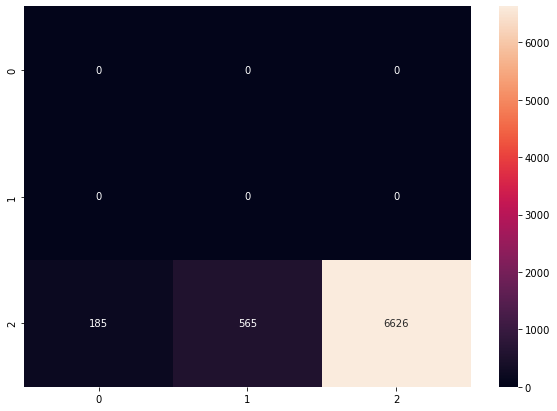

In [5]:
# Baseline model -- would just predict 3 everytime

constant_pred = np.repeat(3, test.shape[0])
constant_pred = np.repeat(3, test.shape[0])

base_acc = accuracy_score(constant_pred, test_Y)
print("Accuracy from constant prediction model: ", base_acc)
base_conf = confusion_matrix(constant_pred, test_Y)

plt.figure(figsize = (10,7))
sn.heatmap(base_conf, annot=True,  fmt='g')


In [6]:
# resampling or other feature engineering techniques
sm = SMOTE()
dev_SMOTE = sm.fit_resample(dev_X, dev_Y)
dev_SMOTE_X = dev_SMOTE[0]
dev_SMOTE_Y = dev_SMOTE[1]

/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[23:11:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy from default XG Boost: 0.886117136659436


/Users/elijahflomen/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


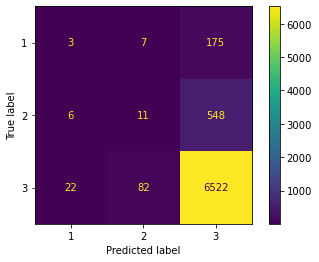

In [7]:
# build model
xg = XGBClassifier()
xg.fit(dev_SMOTE_X, dev_SMOTE_Y)
preds = xg.predict(test_X)
xg_acc = accuracy_score(test_Y, preds)
print("Accuracy from default XG Boost:", xg_acc)
plot_confusion_matrix(xg, test_X, test_Y)

In [9]:
# validation
xg_boost_model = XGBClassifier(eval_metric='logloss')
xg_boost_model.fit(dev_SMOTE_X, dev_SMOTE_Y)
xg_bost_score = xg_boost_model.score(test_X, test_Y)
print(f"Untuned XGBoost model has a performance of : {xg_bost_score}")

xg_boost_grid_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.05, 0.1, 0.3], 'max_depth': [2, 4, 6]}

xg_boost_rand = GridSearchCV(estimator = xg_boost_model, param_grid= xg_boost_grid_params, verbose=5, cv=5)
# # Fit the random search model
xg_boost_rand.fit(dev_SMOTE_X, dev_SMOTE_Y)

print(f" The optimal XG Boost params were found to be {xg_boost_rand.best_params_}, with a validation score of {xg_boost_rand.best_score_}")
plot_confusion_matrix(xg_boost_rand, test_X, test_Y)

Untuned XGBoost model has a performance of : 0.886117136659436


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
optimal_xg = XGBClassifier(eta = 0.05, max_depth = 6, n_estimators= 100)
optimal_xg = optimal_xg.fit(dev_SMOTE_X, dev_SMOTE_Y)

[22:56:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

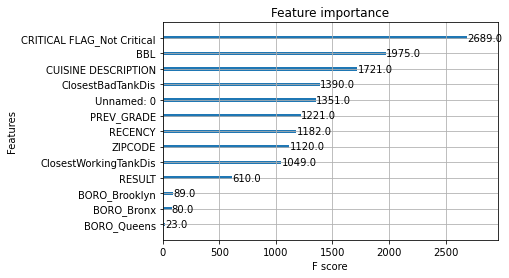

In [ ]:
plot_importance(optimal_xg)

In [ ]:
# visualization